# Daily Forecast Example

Daily forecast is one of most popular use cases in time-series modeling. In this example, it aims to introduce a way to perform a daily forecast by modeling yearly and weekly seasonality together. We will use the aggregated number of sales from the [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).

In [1]:
import pandas as pd
import numpy as np
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

For demo purpose, we just use a subset of regressors and perform log transformation on response to construct a multiplicative model.

In [2]:
df = pd.read_csv('./data/m5_agg_demand.csv', parse_dates=['date'])
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]
df = df[["date", "sales"] + regressor_col]
df['sales_log1p'] = np.log1p(df['sales'])
df.head(5)

,date,sales,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear,sales_log1p
0,2011-01-29,32631,0,0,0,0,0,0,0,10.393049
1,2011-01-30,31749,0,0,0,0,0,0,0,10.365648
2,2011-01-31,23783,0,0,0,0,0,0,0,10.076768
3,2011-02-01,25412,0,0,0,0,0,0,0,10.143016
4,2011-02-02,19146,0,0,0,0,0,0,0,9.859901


In [3]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

Note that `level_sm_input` are used to fix level smoothing parameter. This is recommended in daily or higher frequency data.

In [4]:
dlt = DLTFull(
    response_col='sales_log1p',
    date_col='date',
    seasonality=7,
    seed=2020,
    is_multiplicative=False,
    regressor_col=regressor_col,
    level_sm_input=0.3, # recommend for higher frequency data
    regressor_sigma_prior=[0.5] * len(regressor_col),
    regression_penalty='lasso',
    period=365,
    prediction_percentiles=[5,95]
)

In [5]:
dlt.fit(train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
predicted_df = dlt.predict(df=test_df)
predicted_df[[5, 95, 'prediction']] = predicted_df[[5, 95, 'prediction']].apply(np.expm1)
predicted_df.head(5)

,date,5,prediction,95
0,2016-03-28,34056.217344,38570.083128,42581.955156
1,2016-03-29,31593.039245,36014.067446,40193.133509
2,2016-03-30,31298.206328,35054.155597,40214.904364
3,2016-03-31,30153.148187,35438.476622,39869.286833
4,2016-04-01,34511.058871,40039.683480,45412.674976


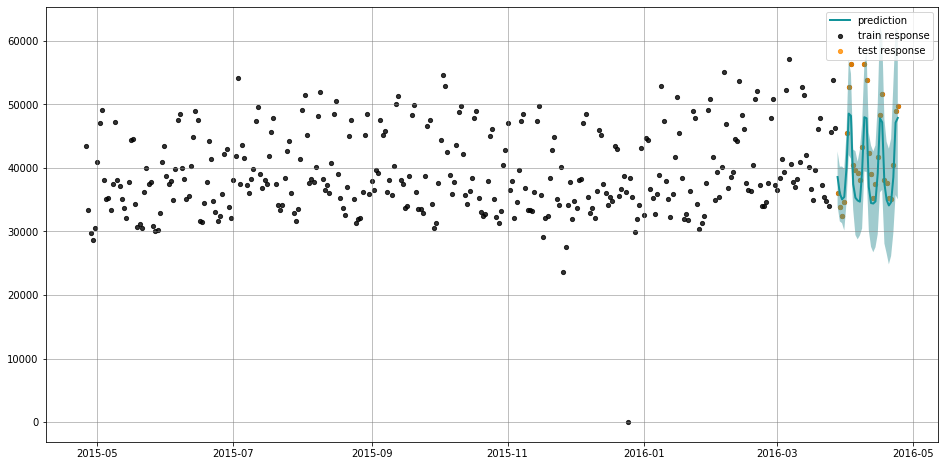

In [7]:
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-365:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    pred_quantiles_col=[5,95],
                    actual_col='sales', pred_col='prediction')